Flavien Moise, Tenzin Nargee, Charlie Payne, Duncan Tanner

5.7.2024

Professor Johnson

DS 3001

# Voting Project Findings

## Summary
The goal of our project was to build predictive models for the 2024 presidential election results in the state of Virginia. To do so, we used voting data from 2000 to 2020 on presidential elections in Virginia, as well as county-level data. We first used an exploratory data analysis to gain a clear understanding of what the data looks like. Our predictive models included a neural network and linear regression, which were used to predict a winner of the 2024 Virginia election, either Democrat (D) or Republican (R). We faced a handful of challenges in the data-cleaning process, significantly limiting our freedom of prediction and overall results. The data, overall, was noisy, a problem for us when addressing data scaling and normalization, which led to worse results and weaker predictions.

## Data
We began our process by cleaning data from “voting_VA.” We dropped unnecessary columns, such as “Unnamed: 0” using “df.drop()”. We then examined the consistency of the data, using .unique(), to ensure the data only included variables that were looking for, including state, state_po, office, and mode. We wanted to ensure the data only included information on Virginia votes for President and checked to see if any action was needed. 
We decided to examine correlations between voting including the mode as an independent variable, so we used “.astype(‘category’)” to provide a data frame where the modes aggregate all individual records across different voting modes into a single record per candidate per county per election year. We put this data into a new data frame called “df_aggregated.”
The next step in cleaning was to drop unimportant information from the aggregated data frame, such as candidate and third-party information. We then reorganized the data into “df_real,” after merging and dropping some more columns, we created “df_final.” After creating “df_final,” we converted column data into the same data type: “str,” and then merged it with “df_melt,” which was provided. 

In [10]:
import numpy as np
import pandas as pd

df = pd.read_csv("data/voting_VA.csv")

print(df.head())
print(df.isnull().sum())

   Unnamed: 0  year     state state_po county_name  county_fips        office  \
0       11161  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
1       11162  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
2       11163  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
3       11164  2000  VIRGINIA       VA    ACCOMACK        51001  US PRESIDENT   
4       11165  2000  VIRGINIA       VA   ALBEMARLE        51003  US PRESIDENT   

        candidate       party  candidatevotes  totalvotes   version   mode  
0         AL GORE    DEMOCRAT            5092       11925  20220315  TOTAL  
1  GEORGE W. BUSH  REPUBLICAN            6352       11925  20220315  TOTAL  
2     RALPH NADER       GREEN             220       11925  20220315  TOTAL  
3           OTHER       OTHER             261       11925  20220315  TOTAL  
4         AL GORE    DEMOCRAT           16255       36846  20220315  TOTAL  
Unnamed: 0        0
year              0
state      

In [11]:
# Remove the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Check unique values for certain columns to ensure consistency
print(df['state'].unique())  # Should only contain "VIRGINIA"
print(df['state_po'].unique())  # Should only contain "VA"
print(df['office'].unique())  # Should only contain "US PRESIDENT"
print(df['mode'].unique())  # Check if any action is needed

['VIRGINIA']
['VA']
['US PRESIDENT']
['TOTAL' 'ABSENTEE' 'ELECTION DAY' 'PROVISIONAL']


In [12]:
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: object

In [13]:
# If we're interested in overall voting results without differentiating between the modes:
# df_total = df[df['mode'] == 'TOTAL']
# df_total.to_csv("data/clean_total_voting_VA.csv", index=False) 

# Otherwise, we can keep all of the modes of voting and use them as features
# in our models
df['mode'] = df['mode'].astype('category')
df['mode'].head()

0    TOTAL
1    TOTAL
2    TOTAL
3    TOTAL
4    TOTAL
Name: mode, dtype: category
Categories (4, object): ['ABSENTEE', 'ELECTION DAY', 'PROVISIONAL', 'TOTAL']

In [14]:
# Provides a dataframe where the modes aggregates all individual records across different voting modes 
# into a single record per candidate per county per election year. 

df_aggregated = df.groupby(['year', 'county_name', 'county_fips', 'candidate', 'party']).agg({
    'candidatevotes': 'sum',
    'totalvotes': 'max'  # Assuming totalvotes is the same across all modes, otherwise sum might be needed
}).reset_index()

df_aggregated.head()

,year,county_name,county_fips,candidate,party,candidatevotes,totalvotes
0,2000,ACCOMACK,51001,AL GORE,DEMOCRAT,5092,11925
1,2000,ACCOMACK,51001,GEORGE W. BUSH,REPUBLICAN,6352,11925
2,2000,ACCOMACK,51001,OTHER,OTHER,261,11925
3,2000,ACCOMACK,51001,RALPH NADER,GREEN,220,11925
4,2000,ALBEMARLE,51003,AL GORE,DEMOCRAT,16255,36846


In [15]:
# Removing candidates column (unimportant)
df_real = df_aggregated.drop('candidate', axis=1)

# Removing third parties (also unimportant)
df_real = df_real[~df_real['party'].isin(['OTHER', 'GREEN'])]

# Finding net total votes
df_real['net_total'] = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes'])['candidatevotes'].transform(lambda x: x.iloc[1] - x.iloc[0])

# Merging columns
df_real = df_real.groupby(['year', 'county_name', 'county_fips', 'totalvotes', 'net_total']).agg({'party': ', '.join}).reset_index()
df_real['winner'] = df_real['net_total'].apply(lambda x: 'REPUBLICAN' if x > 0 else 'DEMOCRAT')
# Dropping some more columns
df_real = df_real.drop(['party', 'totalvotes'], axis=1)
df_final = df_real[['year', 'county_name', 'county_fips','net_total', 'winner']]
df_final.head()

,year,county_name,county_fips,net_total,winner
0,2000,ACCOMACK,51001,1260,REPUBLICAN
1,2000,ALBEMARLE,51003,2036,REPUBLICAN
2,2000,ALEXANDRIA,51510,-14590,DEMOCRAT
3,2000,ALLEGHANY,51005,594,REPUBLICAN
4,2000,AMELIA,51007,1193,REPUBLICAN


In [16]:
df_melt = pd.read_csv("data/df_melt.csv")

year_mapping = {
    2000: 2000,
    2004: 2000,
    2008: 125,
    2012: 125,
    2016: 195,
    2020: 195
}
df_final['melt_year'] = df_final['year'].map(year_mapping)

# Convert columns to the same data type before merging
df_final['melt_year'] = df_final['melt_year'].astype(str)
df_final['county_fips'] = df_final['county_fips'].astype(str)
df_melt['YEAR'] = df_melt['YEAR'].astype(str)
df_melt['FIPS'] = df_melt['FIPS'].astype(str)

merged_df = pd.merge(df_final, df_melt, left_on=['melt_year', 'county_fips'], right_on=['YEAR', 'FIPS'])

columns_to_drop = ['YEAR', 'FIPS', 'melt_year']
df_updated = merged_df.drop(columns=columns_to_drop)

print(df_updated.head())

   year county_name county_fips  net_total      winner     AV0AA     B78AA  \
0  2000    ACCOMACK       51001       1260  REPUBLICAN   38305.0   38305.0   
1  2004    ACCOMACK       51001      -2208    DEMOCRAT   38305.0   38305.0   
2  2000   ALBEMARLE       51003       2036  REPUBLICAN   79236.0   79236.0   
3  2004   ALBEMARLE       51003        899  REPUBLICAN   79236.0   79236.0   
4  2000  ALEXANDRIA       51510     -14590    DEMOCRAT  128283.0  128283.0   

     AV1AA    AV1AB    AT5AA  ...   A88AD    A88AE    AB2AA    BD5AA  \
0  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
1  18590.0  19715.0  36680.0  ...  3781.0   3195.0  34821.0  16309.0   
2  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
3  38002.0  41234.0  73483.0  ...  5153.0  13401.0  63407.0  28852.0   
4  61974.0  66309.0  95683.0  ...  6275.0  17685.0  67023.0  37645.0   

      AX6AA    CL6AA    AX7AA     AX7AB  BV8AA   BV8AB  
0   37715.0   6788.0   6788.0   30927.0  

In [17]:
df_updated = df_updated.drop(columns=['winner'])
df_updated = pd.get_dummies(df_updated, columns=['county_name'])
df_updated = df_updated.astype(float)

#### Challenges:
Our biggest challenge in the cleaning process was merging county voting data with county data based on year and fids. We ran into significant bugs and index errors with the concatenation of these two data and ultimately used “df_melt” to get around these problems before running our regression.
Bugs were a huge limitation in our process.

## Results

#### EDA
The initial steps for the Exploratory Data Analysis involved loading the data, normalizing numeric variables using a MinMaxScaler, and transforming certain skewed variables using the arcsinh transformation. The transformation of “net_total” into “net_total_ihs” using the arcsinh function is meant to stabilize variance and normalize the distribution of heavily skewed variables.
The resulting graphs were quite messy. Looking at the scatter plots, we can see that many plots show a strong linear relationship, a good sign for linear predictive modeling. 

year                           0
county_fips                    0
net_total                      0
AV0AA                          1
B78AA                          1
                              ..
county_name_WINCHESTER         0
county_name_WINCHESTER CITY    0
county_name_WISE               0
county_name_WYTHE              0
county_name_YORK               0
Length: 330, dtype: int64


/tmp/ipykernel_799299/3079268672.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()  # Adjust subplots to fit into figure area.


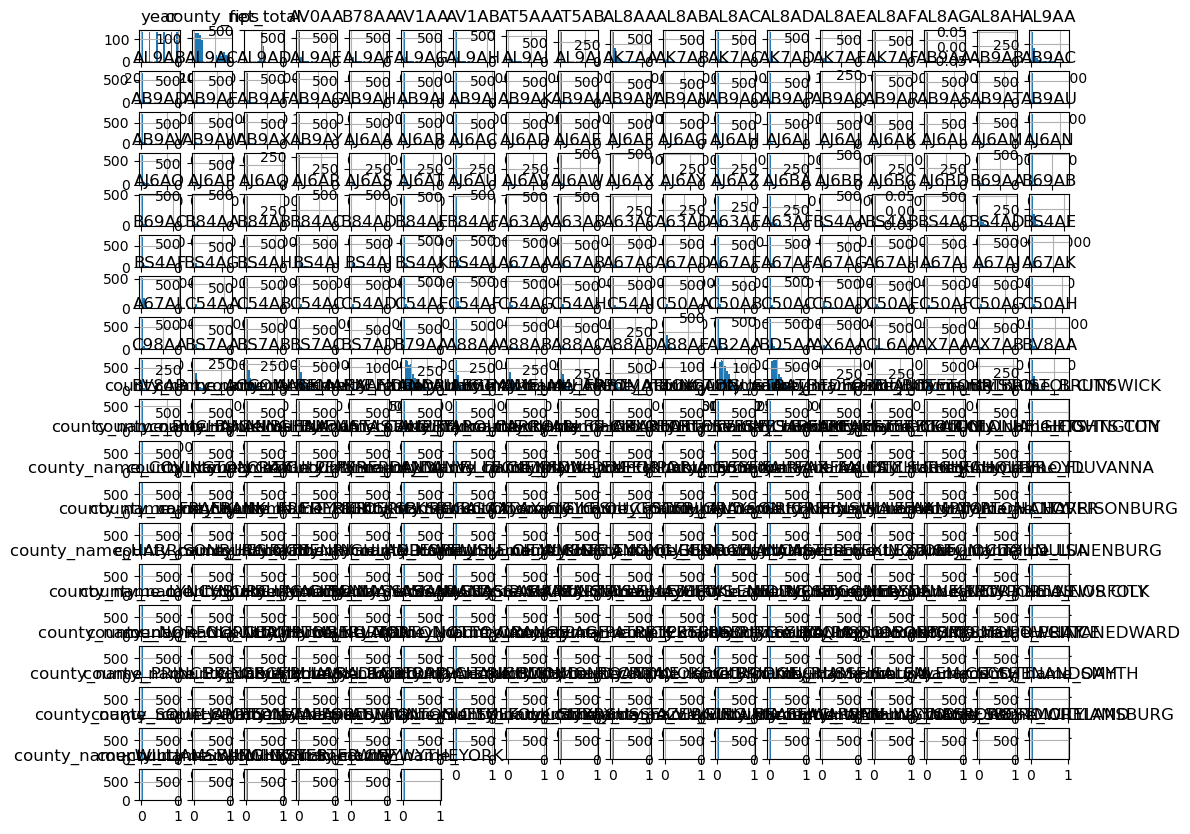

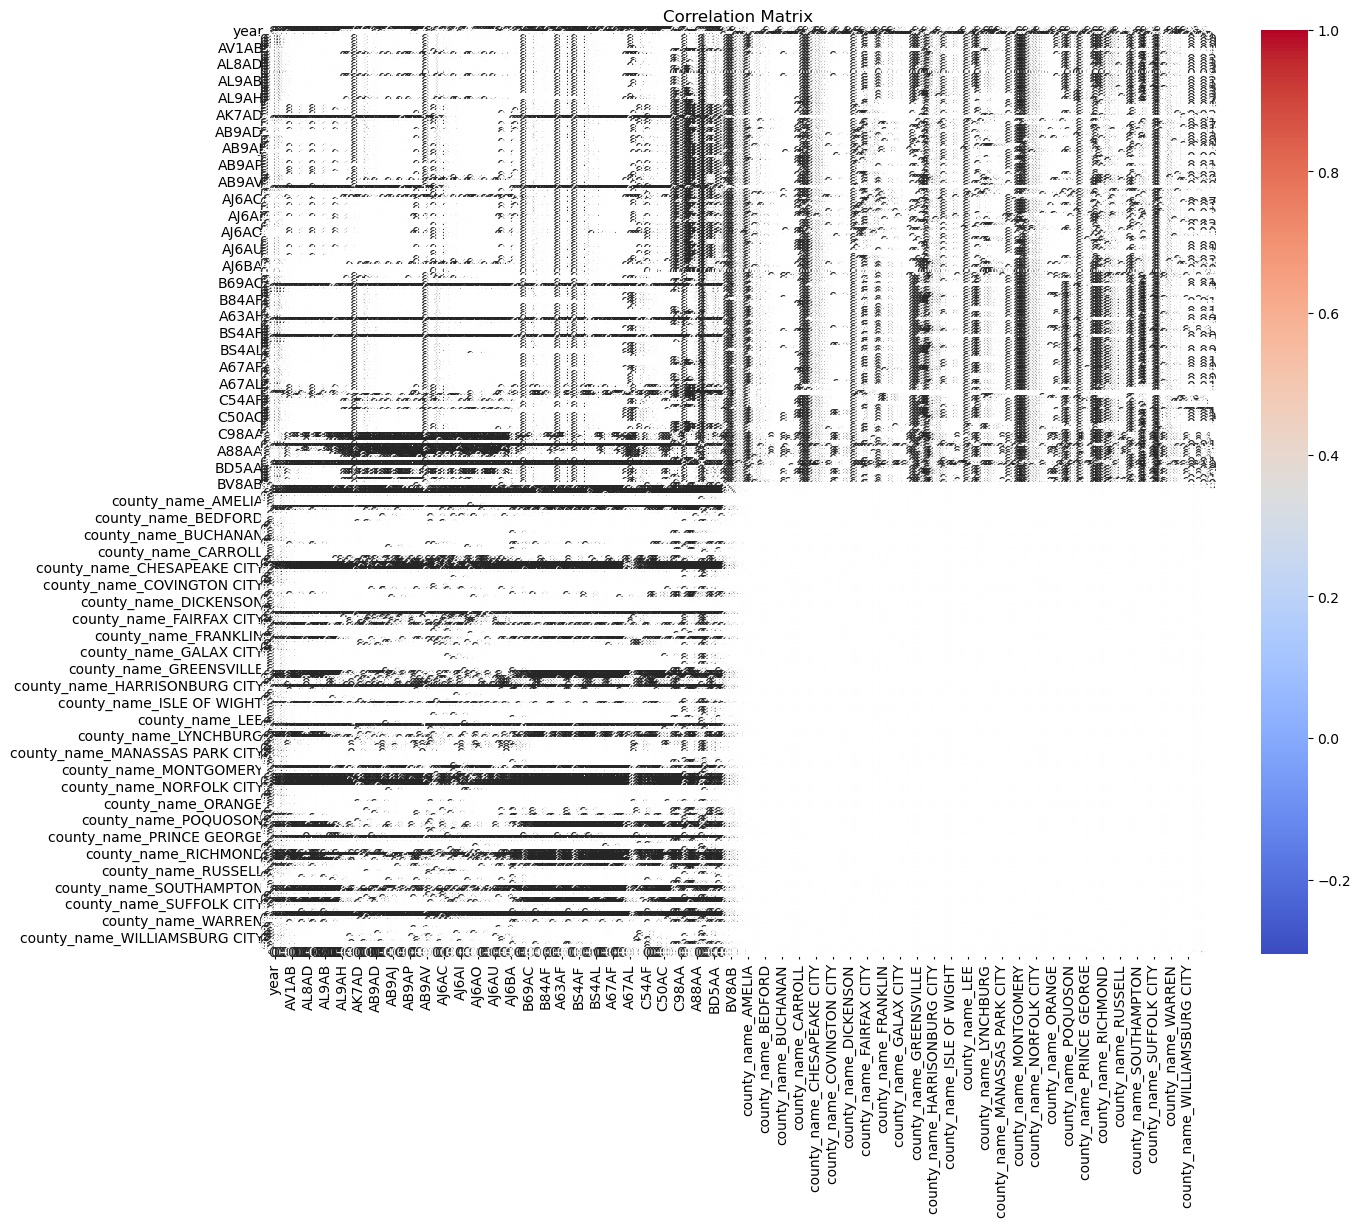

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


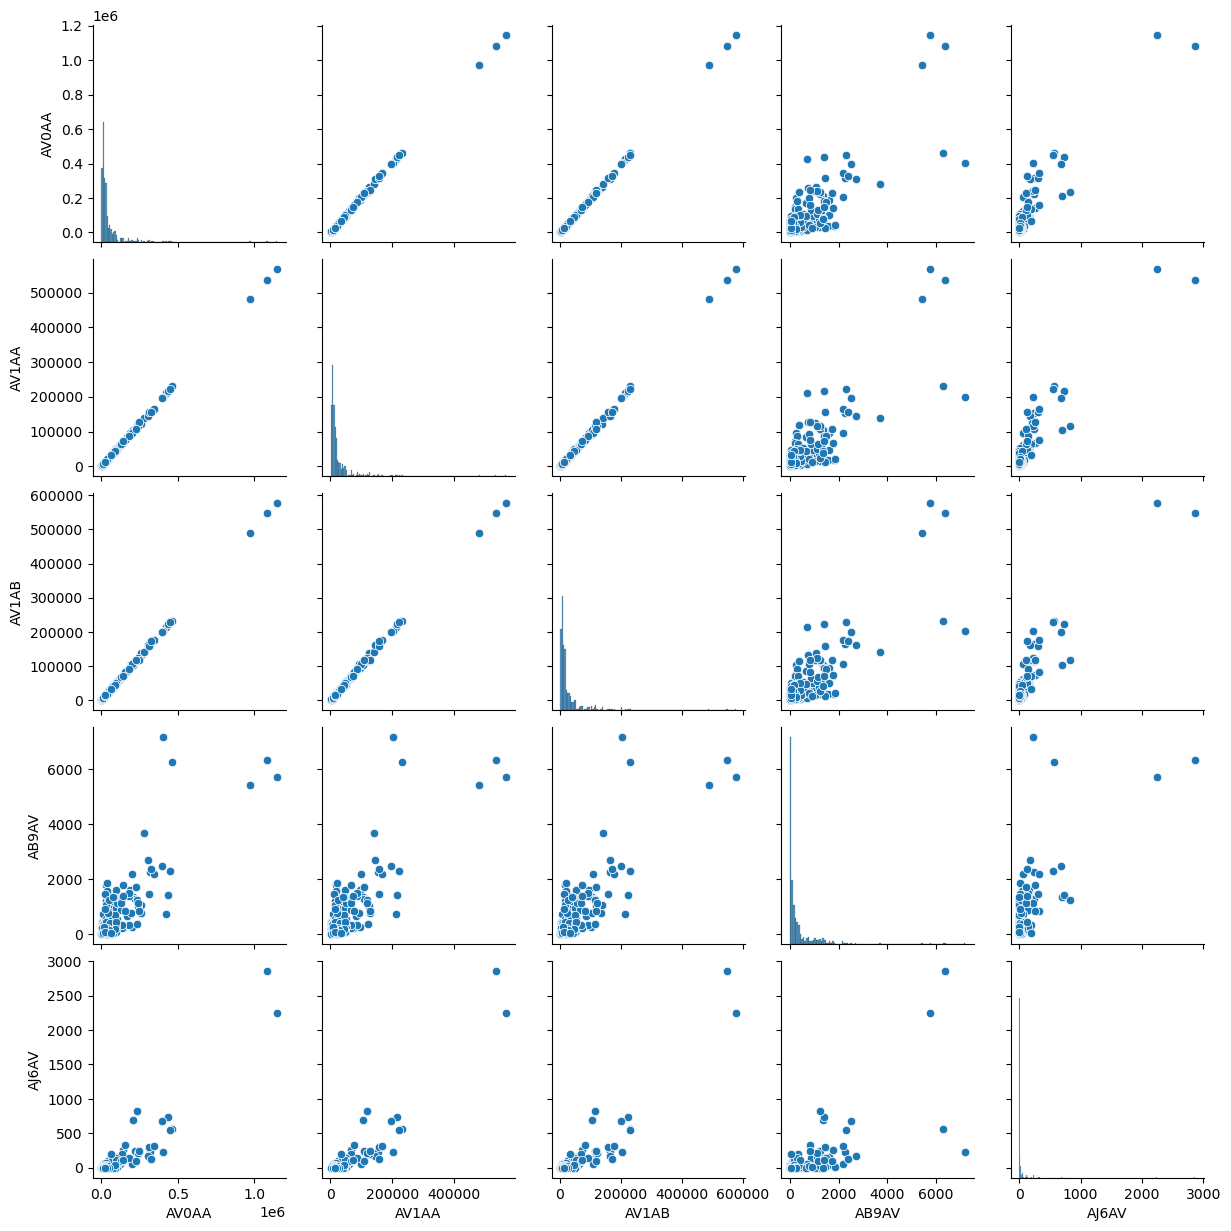

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

df_eda = df_updated.copy(deep=True)


# Check for missing values
print(df_eda.isnull().sum())

# Histograms for numeric data to understand distributions
df_eda.hist(figsize=(12, 10), bins=20)
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

''' # Boxplots for numerical columns to visualize outliers
numeric_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
fig, ax = plt.subplots(len(numeric_cols), 1, figsize=(10, len(numeric_cols)*4))
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(f'Boxplot for {col}', fontsize=12)
plt.tight_layout()
plt.show()
'''

# Correlation matrix to explore potential relationships
corr_matrix = df_eda.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Pairplot for selected features including the transformed net_total
selected_features = [col for col in df_eda.columns if 'AV' in col][:5]  # example with AV columns
sns.pairplot(df_eda[selected_features])
plt.show()


In [19]:
#normalize net_total using inverse hyperbolic arcsin
df_updated['net_total'] = np.arcsinh(df_updated['net_total'])
#normalize the rest of the variables (they're all counts) except for 'year', 'net_total' and 'county_fips'
scaler = MinMaxScaler()
numeric_cols = df_updated.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['year', 'county_fips', 'net_total']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
df_updated[numeric_cols] = scaler.fit_transform(df_updated[numeric_cols])

print(df_updated.head())

df_2020 = df_updated[df_updated['year'] == 2020]
df_total = df_updated[df_updated['year'] != 2020]
df_2020.reset_index(drop=True, inplace=True)
df_total.reset_index(drop=True, inplace=True)

     year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  2000.0      51001.0   7.832014  0.031566  0.031566  0.030908  0.032214   
1  2004.0      51001.0  -8.392990  0.031566  0.031566  0.030908  0.032214   
2  2000.0      51003.0   8.311890  0.067356  0.067356  0.065137  0.069538   
3  2004.0      51003.0   7.494431  0.067356  0.067356  0.065137  0.069538   
4  2000.0      51510.0 -10.281239  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  county_name_WAYNESBORO  \
0  0.043935  0.004512  0.067998  ...                     0.0   
1  0.043935  0.004512  0.067998  ...                     0.0   
2  0.090827  0.016016  0.121790  ...                     0.0   
3  0.090827  0.016016  0.121790  ...                     0.0   
4  0.119113  0.090837  0.085127  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0  

/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


#### Neural Network
We started our analysis with a neural network after getting past challenges with cleaning the data. The neural network model was employed to predict net total votes defined in the data frame “df_total.” Data was split into training and testing samples at an 80:20 ratio. The model consisted of three layers configured with 64, 32, and 1 units, respectively. We used a Rectified Linear Unit activation function for the first three layers, and a linear activation function for the output layer. We used the Adam optimizer and mean squared error as the loss function, and mean absolute error (MAE) and mean squared error (MSE) as performance tracking metrics. 

We evaluated the model using the training data. Initial testing showed a loss/MSE of 218362576.0 and an MAE of 6693.91. The results showed high error, suggesting potential issues including overfitting or inadequately captured interactions between features.
After using training data, we applied the model to predict results based on the 2020 election, since data from that year is closest to the next election, and thus more helpful. We summed all predictions from 2020 data to create one prediction for the 2024 election. Our resulting prediction was that Republicans  would win by a margin of 3.4022. 

We checked the accuracy of this precision using previously mentioned metrics. Using 2020 data, loss/MSE was 94.948, and MAE was 9.686. The loss and MSE were relatively high, suggesting that the model’s predictions vary significantly from actual values. These results indicate significant prediction errors on average and that the neural network model does not perform optimally for this intended task. 


In [20]:
# Neural network time!
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split


y = df_total['net_total'].astype(float)
X = df_total.drop('net_total', axis=1).astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

net = Sequential()
#Having 3 layers results in Loss: 218362592.0, Mean Absolute Error (MAE): 6693.912109375, Mean Squared Error (MSE): 218362592.0
net.add(Dense(units=82, activation='relu', input_dim=X_train.shape[1]))
#net.add(Dense(units=32, activation='relu'))
net.add(Dense(units=1, activation='linear'))

net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

net.fit(X_train, y_train, epochs=25, verbose=1, batch_size=50)

# use it to predict testing data
evaluation = net.evaluate(X_test, y_test)

# Extract the evaluation metrics
loss = evaluation[0]
mae = evaluation[1]
mse = evaluation[2]
print("Evaluation metrics:")
print(f"Loss: {loss}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

2024-05-07 21:32:17.786398: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 21:32:17.787357: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 21:32:17.791078: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 21:32:17.832714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 21:32:28.352919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Epoch 1/25


/home/ghf3ky/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-07 21:32:32.184254: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 70.6455 - mae: 8.2513 - mse: 70.6455  
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.5722 - mae: 8.2231 - mse: 70.5722 
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.2377 - mae: 8.2280 - mse: 70.2377 
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.5085 - mae: 8.2468 - mse: 70.5085 
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.1364 - mae: 8.1420 - mse: 69.1364 
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.6693 - mae: 8.2756 - mse: 70.6693 
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.6325 - mae: 8.2605 - mse: 70.6325 
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71.0232 - mae: 8.2767 - mse: 71.0232 
Epoch 9/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.2035 - mae: 8.1447 - mse: 69.2035 
Epoch 10/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70.9467 - mae: 8.2673 - mse: 70.9467 
Epoch 11/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [22]:
# Then use it to predict data from 2020 election since it's closest to current election
test_2020 = df_2020.drop('net_total', axis=1)
print(test_2020.head())
predictions_2020 = net.predict(test_2020)

# Sum all the predictions
total_prediction = predictions_2020.sum()

# Check if the total prediction is positive, negative, or zero
if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

     year  county_fips     AV0AA     B78AA     AV1AA     AV1AB     AT5AA  \
0  2020.0      51001.0  0.026642  0.026642  0.026224  0.027052  0.035612   
1  2020.0      51003.0  0.091986  0.091986  0.088697  0.095222  0.119821   
2  2020.0      51510.0  0.135888  0.135888  0.132059  0.139654  0.143315   
3  2020.0      51005.0  0.011326  0.011326  0.011118  0.011531  0.016270   
4  2020.0      51007.0  0.009399  0.009399  0.009730  0.009073  0.013514   

      AT5AB     AL8AA     AL8AB  ...  county_name_WAYNESBORO  \
0  0.007020  0.054705  0.022307  ...                     0.0   
1  0.031105  0.155589  0.091887  ...                     0.0   
2  0.119643  0.103680  0.156921  ...                     0.0   
3  0.000513  0.032698  0.005539  ...                     0.0   
4  0.000399  0.028323  0.003785  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0        

In [23]:
#Then evaluate the actual accuracy of the prediction. 
evaluation_2020 = net.evaluate(df_2020.drop('net_total', axis=1), df_2020['net_total'])

# Extract the evaluation metrics
loss_2020 = evaluation_2020[0]
mae_2020 = evaluation_2020[1]
mse_2020 = evaluation_2020[2]
print("Evaluation metrics on 2020 data:")
print(f"Loss: {loss_2020}")
print(f"Mean Absolute Error (MAE): {mae_2020}")
print(f"Mean Squared Error (MSE): {mse_2020}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94.4292 - mae: 9.6585 - mse: 94.4292 
Evaluation metrics on 2020 data:
Loss: 95.01219177246094
Mean Absolute Error (MAE): 9.689720153808594
Mean Squared Error (MSE): 95.01219177246094


#### Linear Regression

There were 163 NaN values in the data frame, which had to be removed to run a linear regression.  We ran into substantial difficulty replacing these NaN values. We first tried mean/median imputation, but indexing errors prevented the imputation (Ex. “Shape of passed values is (670, 326), indices imply (670, 12)”), Next we tried replacing NaN values with zeros and creating respective binary columns using 1 as an indicator of a missing value. This resulted in significant warnings, such as “PerformanceWarning: DataFrame is highly fragmented,”  due to repeated modifications to the data frame when we replaced NaNs with ‘0’ using “fillna().”

When running the linear regression model, we again split the data into testing and training data, at an 80:20 ratio. We applied the prediction model first to the entire data set, which predicted a Republican win in 2024 by a margin of 56.79. When we just used 2020 data to make a prediction however, we observed a Democrat win by a margin of -1832. The accuracy metrics of the prediction resulted in an MSE of 3108.369 and an r2 of -45.747. The MSE is exceptionally high. This suggests that the model’s predictions deviate significantly from the actual values in the data set, and indicates extremely poor model performance. The r2 of -45.747 is extraordinarily poor. An r2 of 0 would indicate that the model performs no better than a model that predicts the mean of the target variable, disregarding input features. The r2 here indicates that the model performs worse than the baseline model. 
Reasons for such poor performance could be significant underfitting of the data or high variance in the data that the simple linear regression model is poor at comprehending.


In [24]:
df_lr = df_updated.copy()
print(df_lr.isna().sum())

year                           0
county_fips                    0
net_total                      0
AV0AA                          1
B78AA                          1
                              ..
county_name_WINCHESTER         0
county_name_WINCHESTER CITY    0
county_name_WISE               0
county_name_WYTHE              0
county_name_YORK               0
Length: 330, dtype: int64


In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

print(df_lr.head())

     year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  2000.0      51001.0   7.832014  0.031566  0.031566  0.030908  0.032214   
1  2004.0      51001.0  -8.392990  0.031566  0.031566  0.030908  0.032214   
2  2000.0      51003.0   8.311890  0.067356  0.067356  0.065137  0.069538   
3  2004.0      51003.0   7.494431  0.067356  0.067356  0.065137  0.069538   
4  2000.0      51510.0 -10.281239  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  county_name_WAYNESBORO  \
0  0.043935  0.004512  0.067998  ...                     0.0   
1  0.043935  0.004512  0.067998  ...                     0.0   
2  0.090827  0.016016  0.121790  ...                     0.0   
3  0.090827  0.016016  0.121790  ...                     0.0   
4  0.119113  0.090837  0.085127  ...                     0.0   

   county_name_WAYNESBORO CITY  county_name_WESTMORELAND  \
0                          0.0                       0.0   
1                          0.0  

In [26]:
for column in df_lr.columns:
    df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
df_lr.fillna(0, inplace=True)

/tmp/ipykernel_799299/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
/tmp/ipykernel_799299/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lr[f'missing_indicator_{column}'] = df_lr[column].isna().astype(int)
/tmp/ipykernel_799299/1622902478.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [27]:
# Assuming df_total is prepared with necessary preprocessing
df_lr2020 = df_lr[df_updated['year'] == 2020]
df_lrrest = df_lr[df_updated['year'] != 2020]
df_lr2020.reset_index(drop=True, inplace=True)
df_lrrest.reset_index(drop=True, inplace=True)

y = df_lrrest['net_total'].astype(float)
X = df_lrrest.drop('net_total', axis=1).astype(float)

In [28]:
print(X.isna().sum())
print(y.isna().sum())

year                                             0
county_fips                                      0
AV0AA                                            0
B78AA                                            0
AV1AA                                            0
                                                ..
missing_indicator_county_name_WINCHESTER         0
missing_indicator_county_name_WINCHESTER CITY    0
missing_indicator_county_name_WISE               0
missing_indicator_county_name_WYTHE              0
missing_indicator_county_name_YORK               0
Length: 659, dtype: int64
0


In [29]:
imputer = SimpleImputer(strategy='median')
transformed_data = imputer.fit_transform(df_lr)
df_lr = pd.DataFrame(transformed_data, columns=df_lr.columns)

print(df_lr.head())

     year  county_fips  net_total     AV0AA     B78AA     AV1AA     AV1AB  \
0  2000.0      51001.0   7.832014  0.031566  0.031566  0.030908  0.032214   
1  2004.0      51001.0  -8.392990  0.031566  0.031566  0.030908  0.032214   
2  2000.0      51003.0   8.311890  0.067356  0.067356  0.065137  0.069538   
3  2004.0      51003.0   7.494431  0.067356  0.067356  0.065137  0.069538   
4  2000.0      51510.0 -10.281239  0.110242  0.110242  0.107408  0.113030   

      AT5AA     AT5AB     AL8AA  ...  \
0  0.043935  0.004512  0.067998  ...   
1  0.043935  0.004512  0.067998  ...   
2  0.090827  0.016016  0.121790  ...   
3  0.090827  0.016016  0.121790  ...   
4  0.119113  0.090837  0.085127  ...   

   missing_indicator_county_name_WAYNESBORO  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   missing_in

In [30]:
# Training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The LR model
model = LinearRegression()

# Fitting
model.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred = model.predict(X_test)
print("Model Prediction: " , y_pred)

Model Prediction:  [-6.41180981e+00 -5.60970856e+00 -1.04289956e+01 -7.94127740e+00
 -2.55734718e-01 -6.44994672e+00  2.47668975e+01 -2.14087804e+00
  6.51863627e+00  6.48997980e+00 -1.00059010e+01  5.88417278e+00
  1.28445286e+01 -3.52378833e+00 -8.85672992e+00 -9.47288024e-01
  2.75120683e-01 -1.22062260e+01 -1.31287837e+01 -2.02247797e+00
  3.60552196e-01  4.68503125e+00 -1.62395937e+00  7.01227871e+00
  4.13605204e-01  8.12202330e+00  1.39134170e+00 -2.56449837e+00
 -7.45179071e+00  4.33921949e+02 -3.92554378e+00 -5.61255748e+00
  2.50787164e+00  3.50551920e+00  7.76574073e-01  3.93240801e-01
  8.39299110e+00  1.23403182e+01  1.89174974e+00 -9.65678858e+00
 -1.62956245e+01  4.28046953e+01 -1.70243514e+01 -8.88367352e+00
 -4.03658900e+01 -1.60988844e+01 -4.83763889e-01 -6.61749579e+00
 -4.51272976e+00 -3.39650874e+00 -1.68219467e+01 -3.41432215e+00
  4.29134099e+02 -1.06224334e+01  1.43010569e+01  7.53584770e+00
  7.42833333e+00  6.35623249e+00  9.46749184e+00  1.72457880e+00
  2.85

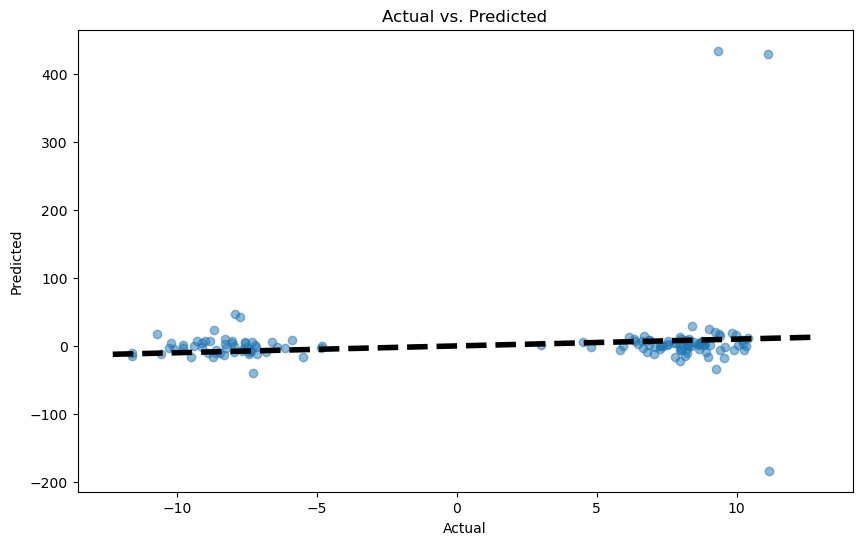

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Line for perfect predictions
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()

In [33]:
# Evaluating model accuracy
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 3108.369226881458
R^2 Score: -45.747408142658806


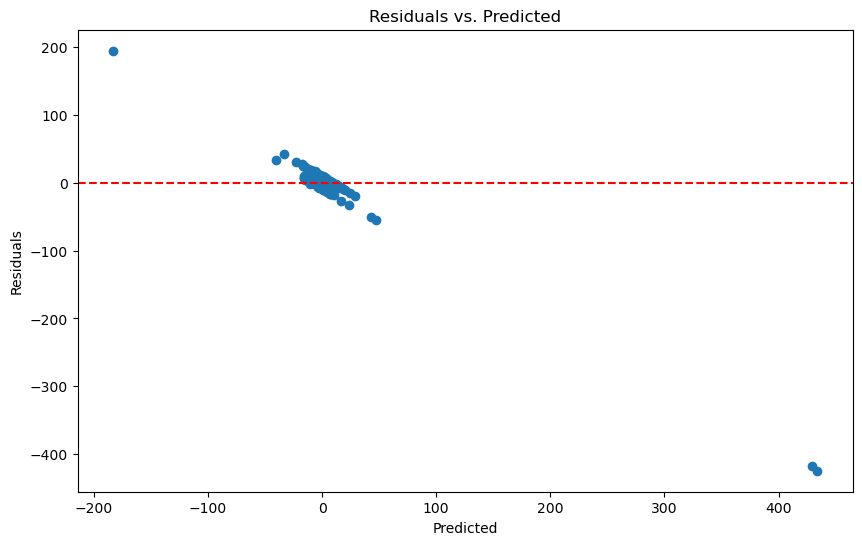

In [34]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted')
plt.show()

In [35]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'VIRGINIA'

In [36]:
#predicting 2024 election with 2020 data, since we dont have 2024 data
lrtest_2020 = df_lr2020.drop('net_total', axis=1)
y_pred2020 = model.predict(lrtest_2020)
total_prediction = y_pred2020.sum()
# Check if the total prediction is positive, negative, or zero
if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

D wins by -1832.5561599059301


Mean Squared Error (MSE): 26.569116470318253
R-squared (R^2) Score: 0.6004215583893462


<Axes: xlabel='net_total'>

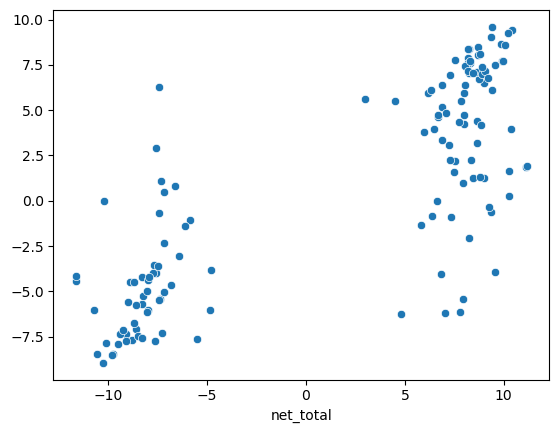

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline

model = RandomForestRegressor()
rf = model.fit(X_train,y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R^2) Score:", r2)
sns.scatterplot(x=y_test, y=y_pred)

In [38]:
pred2020 = rf.predict(df_lr2020.drop('net_total', axis=1))
total_prediction = pred2020.sum()
if total_prediction > 0:
    print("R wins by "+ str(total_prediction))
elif total_prediction < 0:
    print("D wins by "+ str(total_prediction))
else:
    print("Cannot make a prediction.")

D wins by -519.2827901261073


## Conclusion

Our project aimed to develop a predictive framework for the 2024 presidential election results in Virginia using historical voting data paired with county-level data. The process involved data preparation, exploratory data analysis (EDA), and implementing two predictive models: neural network and linear regression. 

We encountered multiple challenges, namely, concatenating the VA county voting data with other county data based on year and FIPS. Ultimately, we turned to the melted CSV to get past these problems. Other limitations of our predictive models included a lack of quality training data and 2024 data, so the best we could do is predict using 2020 data since it is the most recent data. Ultimately, bugs we faced during data cleaning significantly impacted our ability to use a variety of more complex predictive models. 

The EDA was instrumental in uncovering the structure of the data and highlighted some relationships and distributions that were informative in the later predictive models. By normalizing numerical variables and addressing missing values and outliers, we created an aggregated data set to use as a foundation.

Our neural network model, despite tuning, encountered challenges with high loss and MAE, indicating potential overfitting and a failure to capture feature interaction adequately. The model predicted a Democrat win in 2024 by a margin of -3.526. However, the prediction was ultimately weak and faced significant accuracy errors.
The linear regression model showed an extremely high r2 of -45.747 and predicted a Democrat win in 2024 by over 1000 difference. The results from linear regression can be attributed to our challenges in handling missing data and the lack of data scaling and normalization. It also suggests that a linear regression model might be too simple for this inherently complex prediction challenge. 

In reflection, it is clear that the accuracy and reliability of our models need enhancement. Future work could incorporate additional data, such as broader demographic, economic, and more granular voting data, which would address issues with the strength of our training data. We could also incorporate more advanced modeling techniques absent our issues in merging county data.